In [97]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# - !wget https://mirror.jframeworks.com/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!wget https://dlcdn.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
#    https://spark.apache.org/downloads.html -> click on Download Spark: spark-3.5.4-bin-hadoop3.tgz
!tar xvf spark-3.5.5-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark==3.5.5
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.5.5-bin-hadoop3"
#- Run the followings:

--2025-03-03 04:03:49--  https://dlcdn.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400724056 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.5-bin-hadoop3.tgz.6’

spark-3.5.5-bin-had 100%[===================>] 382.16M   249MB/s    in 1.5s    

2025-03-03 04:03:50 (249 MB/s) - ‘spark-3.5.5-bin-hadoop3.tgz.6’ saved [400724056/400724056]

spark-3.5.5-bin-hadoop3/
spark-3.5.5-bin-hadoop3/jars/
spark-3.5.5-bin-hadoop3/jars/HikariCP-2.5.1.jar
spark-3.5.5-bin-hadoop3/jars/JLargeArrays-1.5.jar
spark-3.5.5-bin-hadoop3/jars/JTransforms-3.1.jar
spark-3.5.5-bin-hadoop3/jars/RoaringBitmap-0.9.45.jar
spark-3.5.5-bin-hadoop3/jars/ST4-4.0.4.jar
spark-3.5.5-bin-hadoop3/jars/activation-1.1.1.jar
spark-3.5.5-bin-hadoop3/jars/aircompressor-0.27.jar
spark-3.5.5-bin-hadoop3/jars/

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('LinearReg').getOrCreate()

In [101]:
# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","
file_type = "csv"

df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter).csv("/content/drive/MyDrive/HousingPriceRegression/data/kc_house_data.csv")

In [102]:
df.show()
df.printSchema()

+----------+---------------+----------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|           date|     price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+---------------+----------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|20141013T000000|    221900|       3|        1|       1180|    5650|     1|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650|
|6414100192|20141209T000000|    538000|       3|     2.25|       2570|    7242|     2|         0|   0|        3|    7|      2170|       

In [103]:
from pyspark.sql.functions import col, to_date
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

integer_columns = ['id', 'bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15']
double_columns = ['price', 'bathrooms', 'floors', 'lat', 'long']

for column in integer_columns:
  df = df.withColumn(column, col(column).cast(IntegerType()))

for column in double_columns:
  df = df.withColumn(column, col(column).cast(DoubleType()))

df = df.withColumn('date', to_date(col('date'), 'yyyy-MM-dd'))

df.printSchema()


root
 |-- id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



In [104]:
df.describe().show()

+-------+--------------------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+------------------+
|summary|                  id|             price|         bedrooms|         bathrooms|       sqft_living|          sqft_lot|            floors|          waterfront|               view|         condition|             grade|        sqft_above|     sqft_basement|          yr_built|      yr_renovated|           zipcode|                lat|               long|    sqft_living15|        sqft_lot15|
+-------+--------------------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+-------

In [105]:
from pyspark.sql.functions import col, when, log1p

def winsorize_and_log_transform(df, winsorize_features, log_features, lower_percentile=0.01, upper_percentile=0.99):
    """
    Perform winsorization and log transformation on a PySpark DataFrame.

    Args:
        df (DataFrame): The input PySpark DataFrame.
        winsorize_features (list): List of numeric columns to apply winsorization.
        log_features (list): List of numeric columns to apply log transformation.
        lower_percentile (float): Lower bound percentile (default: 0.01).
        upper_percentile (float): Upper bound percentile (default: 0.99).

    Returns:
        DataFrame: Transformed DataFrame with winsorized and log-transformed values.
    """
    bounds = {}  # Store lower and upper bounds for winsorization

    # Compute percentile values for each column
    for feature in winsorize_features:
        lower_bound, upper_bound = df.approxQuantile(feature, [lower_percentile, upper_percentile], 0.0)
        bounds[feature] = (lower_bound, upper_bound)

    # Apply winsorization
    for feature, (lower_bound, upper_bound) in bounds.items():
        df = df.withColumn(
            feature,
            when(col(feature) < lower_bound, lower_bound)
            .when(col(feature) > upper_bound, upper_bound)
            .otherwise(col(feature))
        )

    # Apply log transformation
    for feature in log_features:
        df = df.withColumn(feature, log1p(col(feature)))  # log(x + 1) to avoid log(0) issues

    return df


In [106]:
winsorize_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
log_features = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

df = winsorize_and_log_transform(df, winsorize_features, log_features)


In [107]:
df.describe().show()

+-------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+--------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+
|summary|                  id|             price|          bedrooms|         bathrooms|      sqft_living|          sqft_lot|            floors|          waterfront|               view|         condition|             grade|         sqft_above|     sqft_basement|          yr_built|      yr_renovated|           zipcode|                lat|               long|     sqft_living15|        sqft_lot15|
+-------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+--------------------+-------------------+------------------+---

In [108]:
df = df.drop('lat', 'long', 'id', 'date')

In [109]:
df.show()

+------------------+--------+---------+------------------+------------------+------+----------+----+---------+-----+------------------+-----------------+--------+------------+-------+-----------------+------------------+
|             price|bedrooms|bathrooms|       sqft_living|          sqft_lot|floors|waterfront|view|condition|grade|        sqft_above|    sqft_basement|yr_built|yr_renovated|zipcode|    sqft_living15|        sqft_lot15|
+------------------+--------+---------+------------------+------------------+------+----------+----+---------+-----+------------------+-----------------+--------+------------+-------+-----------------+------------------+
|12.309986615445005|     3.0|      1.0| 7.074116816197362| 8.639587799629844|   1.0|         0|   0|        3|    7| 7.074116816197362|              0.0|    1955|           0|  98178|7.201170883281678| 8.639587799629844|
|13.195615697878253|     3.0|     2.25| 7.852050207265889| 8.887790764195326|   2.0|         0|   0|        3|    7|

In [110]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)

In [111]:
test_data.show()

+------------------+--------+---------+------------------+-----------------+------+----------+----+---------+-----+------------------+-----------------+--------+------------+-------+------------------+-----------------+
|             price|bedrooms|bathrooms|       sqft_living|         sqft_lot|floors|waterfront|view|condition|grade|        sqft_above|    sqft_basement|yr_built|yr_renovated|zipcode|     sqft_living15|       sqft_lot15|
+------------------+--------+---------+------------------+-----------------+------+----------+----+---------+-----+------------------+-----------------+--------+------------+-------+------------------+-----------------+
|11.289794413577894|     2.0|      1.0| 6.580639137284949|8.527341522468053|   1.0|         0|   0|        2|    4|  6.55250788703459|              0.0|    1912|           0|  98014|7.0909098220799835|8.922791623969637|
|11.326607934898927|     2.0|      1.0| 6.803505257608338|9.057305735807121|   1.0|         0|   0|        3|    5| 6.80

In [112]:
train_data.show()

+------------------+--------+---------+------------------+------------------+------+----------+----+---------+-----+------------------+-------------+--------+------------+-------+------------------+------------------+
|             price|bedrooms|bathrooms|       sqft_living|          sqft_lot|floors|waterfront|view|condition|grade|        sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|     sqft_living15|        sqft_lot15|
+------------------+--------+---------+------------------+------------------+------+----------+----+---------+-----+------------------+-------------+--------+------------+-------+------------------+------------------+
|11.225256725762893|     2.0|      1.0| 6.580639137284949|10.677707679122552|   1.0|         0|   0|        3|    3|  6.55250788703459|          0.0|    1966|           0|  98022| 7.057036981697891|10.666230755983976|
|11.264476926102367|     2.0|      1.0| 6.660575149839686|  9.70167731915831|   1.0|         0|   0|        1|    5| 6.660575149

In [113]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

categorical_features_ordinal = ['bedrooms', 'floors', 'view', 'condition', 'grade']
numerical_features = ['bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'yr_built']

# Ordinal Encoding using StringIndexer
ordinal_indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="keep") for col in categorical_features_ordinal]

# StandardScaler for numerical features
vector_assembler = VectorAssembler(inputCols=numerical_features, outputCol="num_features_vector")
scaler = StandardScaler(inputCol="num_features_vector", outputCol="num_features_scaled", withMean=True, withStd=True)

# One-Hot Encoding for Zipcode
zipcode_indexer = StringIndexer(inputCol="zipcode", outputCol="zipcode_indexed", handleInvalid="keep")
zipcode_encoder = OneHotEncoder(inputCol="zipcode_indexed", outputCol="zipcode_ohe")

# Assemble final features
feature_assembler = VectorAssembler(
    inputCols=[f"{col}_indexed" for col in categorical_features_ordinal] + ["num_features_scaled", "zipcode_ohe"],
    outputCol="final_features"
)

# Define PySpark Pipeline
preprocessor = Pipeline(stages=ordinal_indexers + [vector_assembler, scaler, zipcode_indexer, zipcode_encoder, feature_assembler])


In [114]:
# **Fit only on training data**
fitted_pipeline = preprocessor.fit(train_data)

# Transform both training and test sets
train_df_transformed = fitted_pipeline.transform(train_data)
test_df_transformed = fitted_pipeline.transform(test_data)

In [118]:
train_df_transformed = train_df_transformed.select('price', 'final_features')
train_df_transformed.show()

+------------------+--------------------+
|             price|      final_features|
+------------------+--------------------+
|11.225256725762893|(83,[0,4,5,6,7,8,...|
|11.264476926102367|(83,[0,3,4,5,6,7,...|
|11.302216779257382|(83,[0,3,4,5,6,7,...|
|11.314486721293981|(83,[4,5,6,7,8,9,...|
|11.320565693461432|(83,[0,3,4,5,6,7,...|
|11.338583982516495|(83,[0,4,5,6,7,8,...|
|11.350418300109132|(83,[0,4,5,6,7,8,...|
|11.350418300109132|(83,[0,4,5,6,7,8,...|
|11.367911253546788|(83,[4,5,6,7,8,9,...|
| 11.39640288460621|(83,[3,4,5,6,7,8,...|
|11.407576060361786|(83,[0,4,5,6,7,8,...|
|11.407576060361786|(83,[0,4,5,6,7,8,...|
|11.407576060361786|(83,[0,5,6,7,8,9,...|
|11.407576060361786|(83,[1,3,4,5,6,7,...|
|11.461642696843066|(83,[0,3,4,5,6,7,...|
|11.461642696843066|(83,[0,5,6,7,8,9,...|
|11.461642696843066|(83,[0,4,5,6,7,8,...|
|11.461642696843066|(83,[0,3,4,5,6,7,...|
|11.502885230075814|(83,[0,3,4,5,6,7,...|
| 11.51293546492023|(83,[0,3,4,5,6,7,...|
+------------------+--------------

In [117]:
test_df_transformed = test_df_transformed.select('price', 'final_features')
test_df_transformed.show()

+------------------+--------------------+
|             price|      final_features|
+------------------+--------------------+
|11.289794413577894|(83,[0,3,4,5,6,7,...|
|11.326607934898927|(83,[0,4,5,6,7,8,...|
|11.407020356604264|(83,[0,4,5,6,7,8,...|
|11.407576060361786|(83,[0,4,5,6,7,8,...|
|11.429554725537322|(83,[0,1,4,5,6,7,...|
|11.477308649967686|(83,[4,5,6,7,8,9,...|
| 11.51293546492023|(83,[0,3,4,5,6,7,...|
| 11.51293546492023|(83,[0,4,5,6,7,8,...|
|11.561725152903833|(83,[4,5,6,7,8,9,...|
|11.561725152903833|(83,[3,4,5,6,7,8,...|
|11.566475710526321|(83,[0,3,4,5,6,7,...|
|11.580593459194764|(83,[4,5,6,7,8,9,...|
|11.603688960617083|(83,[0,4,5,6,7,8,...|
|11.608244735642321|(83,[0,3,4,5,6,7,...|
|11.652696102959753|(83,[0,4,5,6,7,8,...|
|11.678448377988165|(83,[0,3,4,5,6,7,...|
|11.728044909070785|(83,[3,4,5,6,7,8,...|
|11.736077016252437|(83,[0,3,4,5,6,7,...|
|11.744045122410057|(83,[0,4,5,6,7,8,...|
|11.775297421715827|(83,[0,3,4,5,6,7,...|
+------------------+--------------

In [119]:
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import log1p

lr = LinearRegression(featuresCol="final_features", labelCol="price")


In [120]:
model = lr.fit(train_df_transformed)

In [121]:
predictions = model.transform(test_df_transformed)

In [122]:
predictions.show(5)

+------------------+--------------------+------------------+
|             price|      final_features|        prediction|
+------------------+--------------------+------------------+
|11.289794413577894|(83,[0,3,4,5,6,7,...|12.296373313742883|
|11.326607934898927|(83,[0,4,5,6,7,8,...| 12.26370815092446|
|11.407020356604264|(83,[0,4,5,6,7,8,...| 12.15745941748325|
|11.407576060361786|(83,[0,4,5,6,7,8,...|12.332782055165719|
|11.429554725537322|(83,[0,1,4,5,6,7,...| 12.00303877855981|
+------------------+--------------------+------------------+
only showing top 5 rows



In [126]:
from pyspark.sql.functions import expm1

## IMPORTANT: Need to convert predictions back to original scale
predictions = predictions.withColumn("price_predicted", expm1(col("prediction")))
predictions = predictions.withColumn("original_price", expm1(col("price")))

In [129]:
predictions.show(5)

+------------------+--------------------+------------------+------------------+-----------------+
|             price|      final_features|        prediction|   price_predicted|   original_price|
+------------------+--------------------+------------------+------------------+-----------------+
|11.289794413577894|(83,[0,3,4,5,6,7,...|12.296373313742883|218899.66331877426|          80000.0|
|11.326607934898927|(83,[0,4,5,6,7,8,...| 12.26370815092446| 211864.7611394242|          83000.0|
|11.407020356604264|(83,[0,4,5,6,7,8,...| 12.15745941748325| 190508.8955765006|89949.99999999993|
|11.407576060361786|(83,[0,4,5,6,7,8,...|12.332782055165719|227016.42489414226|90000.00000000001|
|11.429554725537322|(83,[0,1,4,5,6,7,...| 12.00303877855981|163249.11940454363|92000.00000000007|
+------------------+--------------------+------------------+------------------+-----------------+
only showing top 5 rows



In [130]:
predictions.describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|             price|        prediction|   price_predicted|    original_price|
+-------+------------------+------------------+------------------+------------------+
|  count|              4396|              4396|              4396|              4396|
|   mean|13.049077875901652|13.049267571319929| 526233.3127482252| 539995.0568698817|
| stddev|0.5263320640897787|0.4829075338686377|299478.31300575176|361138.76671988243|
|    min|11.289794413577894|11.923352129289583|150745.08276694323|           80000.0|
|    max|15.744855835388163|15.358538250161502| 4678733.616111537| 6884999.999999994|
+-------+------------------+------------------+------------------+------------------+



In [133]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate RMSE using original numbers for interpretability
rmse_evaluator = RegressionEvaluator(labelCol="original_price", predictionCol="price_predicted", metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)

# Evaluate r squared
r2_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Root Mean Squared Error (RMSE): 151169.43838407524
R² Score: 0.8619948659531752


In [134]:
df_pandas = predictions.toPandas()

In [136]:
df_pandas.head()

,price,final_features,prediction,price_predicted,original_price
0,11.289794,"(2.0, 0.0, 0.0, 3.0, 8.0, -1.4879493311138423,...",12.296373,218899.663319,80000.0
1,11.326608,"(2.0, 0.0, 0.0, 0.0, 6.0, -1.4879493311138423,...",12.263708,211864.761139,83000.0
2,11.407020,"(2.0, 0.0, 0.0, 0.0, 6.0, -1.4879493311138423,...",12.157459,190508.895577,89950.0
3,11.407576,"(2.0, 0.0, 0.0, 0.0, 8.0, -1.4879493311138423,...",12.332782,227016.424894,90000.0
4,11.429555,"(2.0, 2.0, 0.0, 0.0, 6.0, -1.4879493311138423,...",12.003039,163249.119405,92000.0


In [137]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

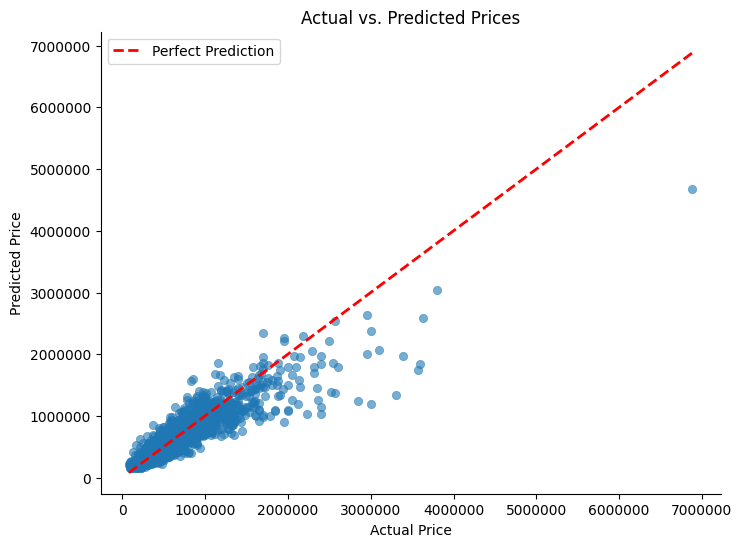

In [138]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pandas['original_price'], y=df_pandas['price_predicted'], alpha=0.6, edgecolor=None)

plt.plot([min(df_pandas['original_price']), max(df_pandas['original_price'])],
         [min(df_pandas['original_price']), max(df_pandas['original_price'])],
         color='red', linestyle='--', linewidth=2, label="Perfect Prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices")

plt.ticklabel_format(style='plain', axis='both')

sns.despine()
plt.legend()
plt.show()


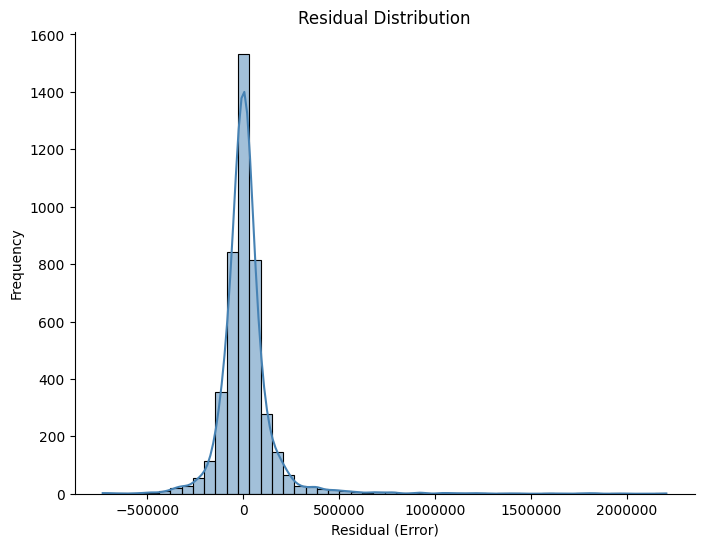

In [139]:
residuals = df_pandas['original_price'] - df_pandas['price_predicted']

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True, color="steelblue")

plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")

plt.ticklabel_format(style='plain', axis='both')

sns.despine()
plt.show()
